In [1]:
import json


jsonToVGLC = {0:"X", 1:"S", 2:"-", 3:"?", 4:"Q", 5:"E", 6:"<", 7:">", 8:"[", 9:"]"}

with open("levels_output.json") as jsonFile:
    jsonLevels = json.loads(jsonFile.read())
for i, level in enumerate(jsonLevels):
    VGLCString = ""
    for levelRow in level:
        for tile in levelRow:
            VGLCString += jsonToVGLC[tile]
        VGLCString += "\n"
    with open(f"Generated Levels\Level {i}", "w") as VGLCLevels:
        VGLCLevels.write(VGLCString.strip())

In [3]:
#I think I'll only use Number of enemies, Power Up mean x and Enemy sparsity
def CalcNumOfEnemies (level):
    NofEnemies = 0
    for y, row in enumerate(level.split('\n')):
        for x, tile in enumerate(row):
            if tile == "E":
                NofEnemies+=1
    return NofEnemies

def CalcPosMeans (level, tileTypes):
    amountOfTile = 0
    sumOfPositions = {'X':0, 'Y':0}
    for y, row in enumerate(level.split('\n')):
        for x, tile in enumerate(row):
            if tile in tileTypes:
                sumOfPositions['X'] += x
                sumOfPositions['Y'] += y
                amountOfTile += 1
    if amountOfTile == 0:
        return {'X':None, "Y":None}
    return {'X': sumOfPositions['X']/amountOfTile, 'Y': sumOfPositions['Y']/amountOfTile}

def CalcStdPos (level, tileTypes):
    posMeans = CalcPosMeans(level, tileTypes)
    amountOfTile = 0
    diffSums = {"X":0,"Y":0}
    for y, row in enumerate(level.split('\n')):
        for x, tile in enumerate(row):
            if tile in tileTypes:
                amountOfTile+=1
                diffSums["X"] += (x - posMeans["X"])**2
                diffSums["Y"] += (y - posMeans["Y"])**2
    if amountOfTile == 0:
        return {'X':None, "Y":None}
    return {"X": diffSums["X"]/amountOfTile, "Y": diffSums["Y"]/amountOfTile}

def CalcTileProportion (level, tileTypes):
    totalTiles = 0
    tileTypeNumber = 0
    for y, row in enumerate(level.split('\n')):
        for x, tile in enumerate(row):
            totalTiles += 1
            if tile in tileTypes:
                tileTypeNumber += 1
    return tileTypeNumber/totalTiles

def CalcEnemySparsity (level):
    posMeans = CalcPosMeans(level, "E")
    amountOfTile = 0
    diffSums = 0
    for y, row in enumerate(level.split('\n')):
        for x, tile in enumerate(row):
            if tile == "E":
                amountOfTile+=1
                diffSums += abs(x - posMeans["X"])
    if amountOfTile == 0:
        return None
    return diffSums/amountOfTile



def WriteLevelMetrics (levelFolderPath, outputFilePath):
    metricsPerLevel = []
    import os, os.path
    for levelName in os.listdir(levelFolderPath):
        metrics = {"NOfEnemies":0, "EnemyStdX":0, "EnemySparsity":0, "EnemyStdY":0, "PipeTopMeanY":0, "PipeStdX": 0, "PipeTopProp": 0}
        tileTypeNums = {}
        with open(f'{levelFolderPath}\\'+levelName) as levelFile:
            level = levelFile.read()
            metrics["NOfEnemies"] = CalcNumOfEnemies(level)
            metrics["EnemyStdX"] = CalcStdPos(level, "E")["X"]
            metrics["EnemySparsity"] = CalcEnemySparsity(level)
            metrics["EnemyStdY"] = CalcStdPos(level, "E")["Y"]
            metrics["PipeTopMeanY"] = CalcPosMeans(level, "<>")["Y"]
            metrics["PipeStdX"] = CalcStdPos(level, "[]")["X"]
            metrics["PipeTopProp"] = CalcTileProportion(level, "<>")
            metricsPerLevel.append(metrics)

    import csv
    keys = metricsPerLevel[0].keys()
    with open(outputFilePath, 'w', newline='')  as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(metricsPerLevel)

def clipLevels (levelFolderPath, width):
    import os, os.path
    import math
    globalFileIndex = 0
    for levelName in os.listdir(levelFolderPath):
        clippedFileHandlers = []
        with open(f"{levelFolderPath}\\{levelName}") as levelFile:
            level = levelFile.read()
            for y, row in enumerate(level.split('\n')):
                for x, tile in enumerate(row):
                    localFileIndex = math.floor(x/width)
                    if x % width == 0:
                        if len(clippedFileHandlers) != 0:
                            clippedFileHandlers[localFileIndex-1].write("\n")
                        clippedLevelFile = open(f"Clipped Levels\Clipped Level {globalFileIndex}", "w")
                        clippedFileHandlers.append(clippedLevelFile)
                    clippedFileHandlers[localFileIndex].write(tile)
                    globalFileIndex += 1
        for fileHandler in clippedFileHandlers:
            fileHandler.close()
def clipLevels(levelFolderPath, width):
    import os, os.path
    import math
    globalFileIndex = 0
    for levelIndex, levelName in enumerate(os.listdir(levelFolderPath)):
        clippedFileHandlers = []
        with open(f"{levelFolderPath}\\{levelName}") as levelFile:
            level = levelFile.read()
            for y, row in enumerate(level.split('\n')):
                for x, tile in enumerate(row):
                    fileIndex = math.floor(x/width)
                    if x % width == 0:
                        if len(clippedFileHandlers) != 0:
                            clippedFileHandlers[fileIndex-1].write("\n")
                        clippedLevelFile = open(f"Clipped Levels\Clipped Level {levelIndex}-{fileIndex}", "w")
                        clippedFileHandlers.append(clippedLevelFile)
                    clippedFileHandlers[fileIndex].write(tile)
        for fileHandler in clippedFileHandlers:
            fileHandler.close()

In [2]:
clipLevels("VGLC levels", 28)

In [4]:
WriteLevelMetrics("Generated Levels", "generated level metrics.csv")
WriteLevelMetrics("Clipped Levels", "VGLC level metrics.csv")

In [1]:
import pandas

VGLCMetrics = pandas.read_csv("VGLC level metrics.csv")
genMetrics = pandas.read_csv("generated level metrics.csv")

In [2]:
VGLCMetrics.describe()

,NOfEnemies,EnemyStdX,EnemySparsity,EnemyStdY,PipeTopMeanY,PipeStdX,PipeTopProp
count,98.000000,81.000000,81.000000,81.000000,42.000000,42.000000,98.000000
mean,2.734694,26.189766,3.557538,1.561458,9.704762,19.311183,0.004321
std,2.161286,28.184305,2.838673,2.296134,0.820125,28.594424,0.006557
min,0.000000,0.000000,0.000000,0.000000,8.000000,0.250000,0.000000
25%,1.000000,0.250000,0.500000,0.000000,9.000000,0.250000,0.000000
50%,2.500000,16.000000,3.750000,0.250000,9.666667,5.625000,0.000000
75%,4.000000,43.760000,6.080000,2.800000,10.000000,27.028237,0.005102
max,8.000000,96.687500,9.750000,10.888889,11.000000,106.739796,0.030612


In [3]:
genMetrics.describe()

,NOfEnemies,EnemyStdX,EnemySparsity,EnemyStdY,PipeTopMeanY,PipeStdX,PipeTopProp
count,100.000000,68.000000,68.000000,68.000000,52.000000,63.000000,100.000000
mean,1.790000,23.136417,3.540041,0.629391,9.677885,5.026576,0.002551
std,1.671478,22.904445,2.709605,2.572498,0.859401,13.519866,0.003012
min,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000
25%,0.000000,0.187500,0.375000,0.000000,9.000000,0.231111,0.000000
50%,2.000000,20.250000,4.375000,0.000000,9.000000,0.250000,0.002551
75%,3.000000,39.463542,5.793333,0.000000,10.666667,0.250000,0.005102
max,6.000000,82.160000,8.500000,16.000000,11.000000,68.222222,0.012755


In [34]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
VGLCScaled = min_max_scaler.fit_transform(VGLCMetrics.values)
genScaled = min_max_scaler.fit_transform(genMetrics.values)
VGLCMetricsScaled = pandas.DataFrame(VGLCScaled, columns=VGLCMetrics.columns)
genMetricsScaled = pandas.DataFrame(genScaled, columns=genMetrics.columns)

In [41]:
rank_compare_2indep(VGLCMetricsScaled["NOfEnemies"], genMetricsScaled["NOfEnemies"], use_t=False).tost_prob_superior(0, 1).pvalue

2.513518573282398e-28

In [52]:
from statsmodels.stats.nonparametric import rank_compare_2indep
oneSidedInterval = 0.4
stepLength = 0.1
testResults = {}
while oneSidedInterval <= 0.9:
    testResults[oneSidedInterval] = {}
    testResults[oneSidedInterval]["NOfEnemies"] = round(rank_compare_2indep(VGLCMetricsScaled["NOfEnemies"], genMetricsScaled["NOfEnemies"], use_t=False).tost_prob_superior(0, oneSidedInterval).pvalue, 3)
    testResults[oneSidedInterval]["EnemyStdX"] = round(rank_compare_2indep(VGLCMetricsScaled["EnemyStdX"].dropna(), genMetricsScaled["EnemyStdX"].dropna(), use_t=False).tost_prob_superior(0, oneSidedInterval).pvalue, 3)
    testResults[oneSidedInterval]["EnemyStdY"] = round(rank_compare_2indep(VGLCMetricsScaled["EnemyStdY"].dropna(), genMetricsScaled["EnemyStdY"].dropna(), use_t=False).tost_prob_superior(0, oneSidedInterval).pvalue, 3)
    testResults[oneSidedInterval]["PipeTopProp"] = round(rank_compare_2indep(VGLCMetricsScaled["NOfEnemies"], genMetricsScaled["NOfEnemies"], use_t=False).tost_prob_superior(0, oneSidedInterval).pvalue, 3)
    testResults[oneSidedInterval]["PipeStdX"] = round(rank_compare_2indep(VGLCMetricsScaled["PipeStdX"].dropna(), genMetricsScaled["PipeStdX"].dropna(), use_t=False).tost_prob_superior(0, oneSidedInterval).pvalue, 3)
    testResults[oneSidedInterval]["PipeTopMeanY"] = round(rank_compare_2indep(VGLCMetricsScaled["PipeTopMeanY"].dropna(), genMetricsScaled["PipeTopMeanY"].dropna(), use_t=False).tost_prob_superior(0, oneSidedInterval).pvalue, 3)
    oneSidedInterval += stepLength

In [53]:
dfTestResults = pandas.DataFrame.from_dict(testResults)

In [54]:
dfTestResults.head(10)

,0.4,0.5,0.6,0.7,0.8,0.9
NOfEnemies,1.000,0.893,0.115,0.000,0.000,0.0
EnemyStdX,0.976,0.452,0.013,0.000,0.000,0.0
EnemyStdY,1.000,1.000,1.000,0.797,0.018,0.0
PipeTopMeanY,1.000,0.999,0.927,0.384,0.021,0.0
PipeStdX,0.960,0.601,0.108,0.003,0.000,0.0
PipeTopProp,1.000,0.893,0.115,0.000,0.000,0.0


In [55]:
dfTestResults.to_excel("Statistical test results.xlsx")

PermissionError: [Errno 13] Permission denied: 'Statistical test results.xlsx'

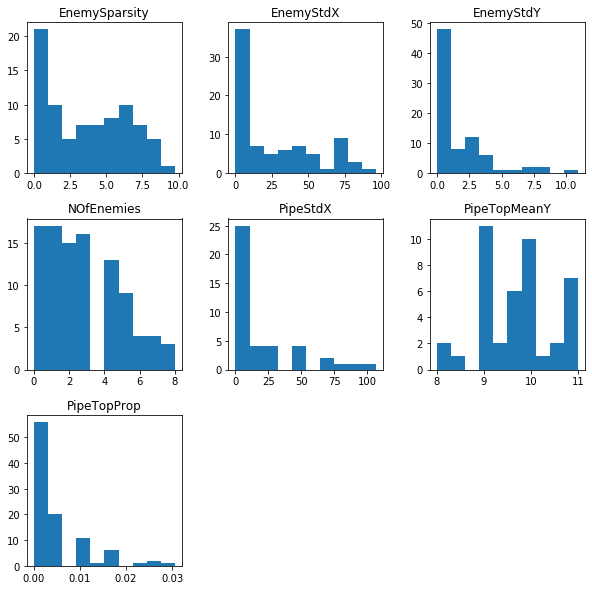

In [162]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
VGLCMetrics.hist(figsize=(10,10), grid=False, ax = ax)
fig.savefig("VGLC metrics histogram.svg")

In [7]:
genMetrics.mean()

NOfEnemies        1.790000
EnemyStdX        23.136417
EnemySparsity     3.540041
EnemyStdY         0.629391
PipeTopMeanY      9.677885
PipeStdX          5.026576
PipeTopProp       0.002551
dtype: float64

In [3]:
genMetrics.std()

NOfEnemies        1.671478
EnemyStdX        22.904445
EnemySparsity     2.709605
EnemyStdY         2.572498
PipeTopMeanY      0.859401
PipeStdX         13.519866
PipeTopProp       0.003012
dtype: float64

In [10]:
droppedGenMetrics = genMetrics.dropna()

In [11]:
droppedGenMetrics.mean()

NOfEnemies        2.953488
EnemyStdX        29.901189
EnemySparsity     4.506072
EnemyStdY         0.364826
PipeTopMeanY      9.455426
PipeStdX          5.715526
PipeTopProp       0.005043
dtype: float64

In [154]:
from statsmodels.stats.weightstats import ttost_ind
oneSidedInterval = 0
stepLength = 0.1
testResults = {}
while oneSidedInterval <= 0.5:
    testResults[oneSidedInterval*2] = {}
    testResults[oneSidedInterval*2]["NOfEnemies"] = round(ttost_ind(VGLCMetricsScaled["NOfEnemies"], genMetricsScaled["NOfEnemies"],
     usevar="unequal", low=-oneSidedInterval, upp=oneSidedInterval)[0], 3)
    testResults[oneSidedInterval*2]["EnemyStdX"] = round(ttost_ind(VGLCMetricsScaled["EnemyStdX"].dropna(), genMetricsScaled["EnemyStdX"].dropna(),
     usevar="unequal", low=-oneSidedInterval, upp=oneSidedInterval)[0], 3)
    testResults[oneSidedInterval*2]["EnemyStdY"] = round(ttost_ind(VGLCMetricsScaled["EnemyStdY"].dropna(), genMetricsScaled["EnemyStdY"].dropna(),
     usevar="unequal", low=-oneSidedInterval, upp=oneSidedInterval)[0], 3)
    testResults[oneSidedInterval*2]["PipeTopMeanY"] = round(ttost_ind(VGLCMetricsScaled["PipeTopMeanY"].dropna(), genMetricsScaled["PipeTopMeanY"].dropna(),
     usevar="unequal", low=-oneSidedInterval, upp=oneSidedInterval)[0], 3)
    testResults[oneSidedInterval*2]["PipeStdX"] = round(ttost_ind(VGLCMetricsScaled["PipeStdX"].dropna(), genMetricsScaled["PipeStdX"].dropna(),
     usevar="unequal", low=-oneSidedInterval, upp=oneSidedInterval)[0], 3)
    testResults[oneSidedInterval*2]["PipeTopProp"] = round(ttost_ind(VGLCMetricsScaled["PipeTopProp"], genMetricsScaled["PipeTopProp"],
     usevar="unequal", low=-oneSidedInterval, upp=oneSidedInterval)[0], 3)
    oneSidedInterval += stepLength